In [1]:
import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt

def show_img(image):
    plt.figure(figsize=(16,16))
    if(len(image.shape) == 2):
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)

In [2]:
train = cv2.imread("../vision/template-2.jpg")
train_gray = cv2.cvtColor(train, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kpTrain, desTrain = sift.detectAndCompute(train_gray, None)

In [3]:
def test(test_gray):
    kpTest, desTest = sift.detectAndCompute(test_gray, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(desTrain, desTest,k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    MIN_MATCH_COUNT = 10
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kpTrain[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kpTest[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = train_gray.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)

        dst = cv2.perspectiveTransform(pts,M)

        ret = np.int32(dst)[:,0,:]

        # at least 0
        ret[ret < 0] = 0
        th,tw = test_gray.shape
        
        # not to exceed width
        mask = np.zeros_like(ret)
        mask[:,0] = 1
        ret[(ret > tw) & (mask == 1)] = tw

        # not to exceed height
        mask = np.zeros_like(ret)
        mask[:,1] = 1
        ret[(ret > th) & (mask == 1)] = th

        return ret

    else:
        print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None
        return None

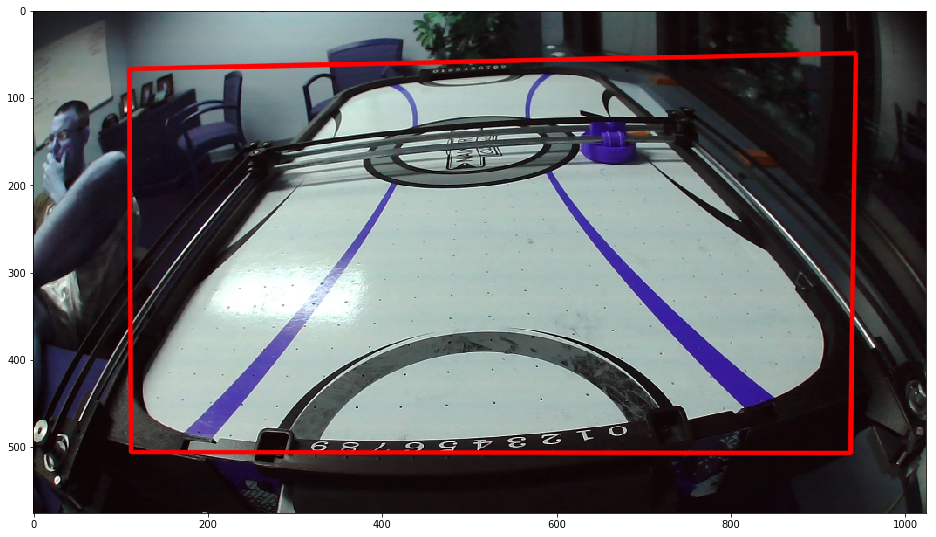

In [5]:
test_img = cv2.imread("./images/night.jpg")
test_img_gray = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
rect = test(test_img_gray)
test_lined = cv2.polylines(test_img.copy(),[rect],True,255,3, cv2.LINE_AA)
show_img(test_lined)

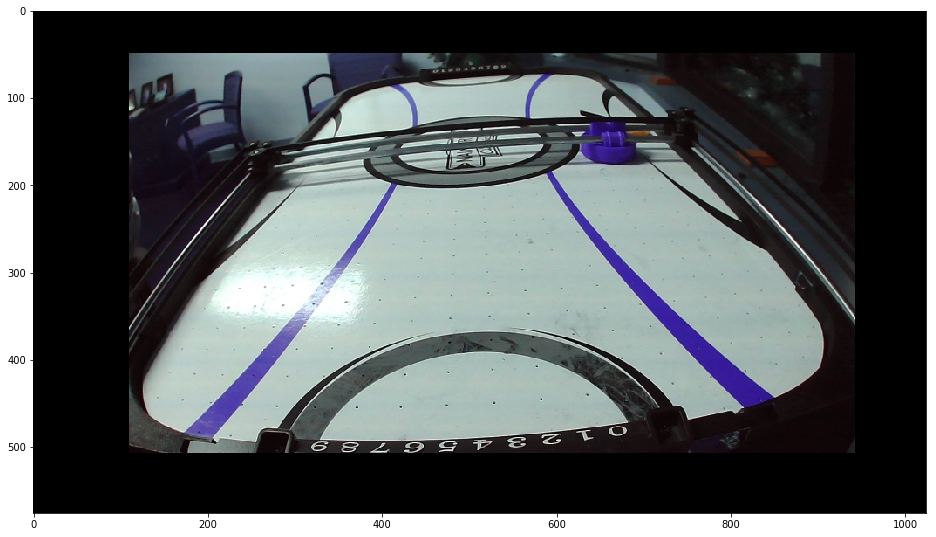

In [6]:
just_rect = np.zeros_like(test_img)
just_rect[min(rect[:,1]):max(rect[:,1]), min(rect[:,0]):max(rect[:,0])] = test_img[min(rect[:,1]):max(rect[:,1]), min(rect[:,0]):max(rect[:,0])]
show_img(just_rect)

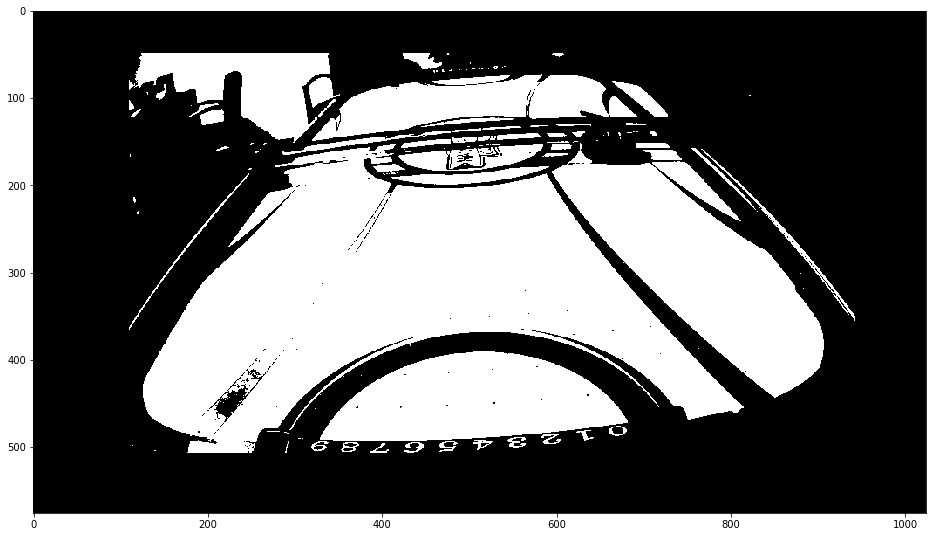

In [8]:
just_gray = cv2.cvtColor(just_rect, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(just_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
show_img(thresh)

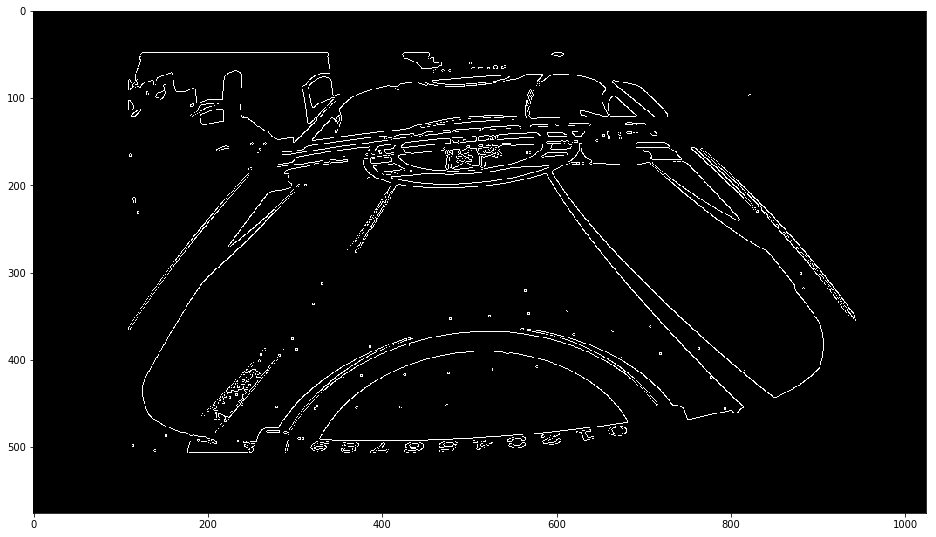

In [9]:
edges = cv2.Canny(thresh, 1, 1)
show_img(edges)

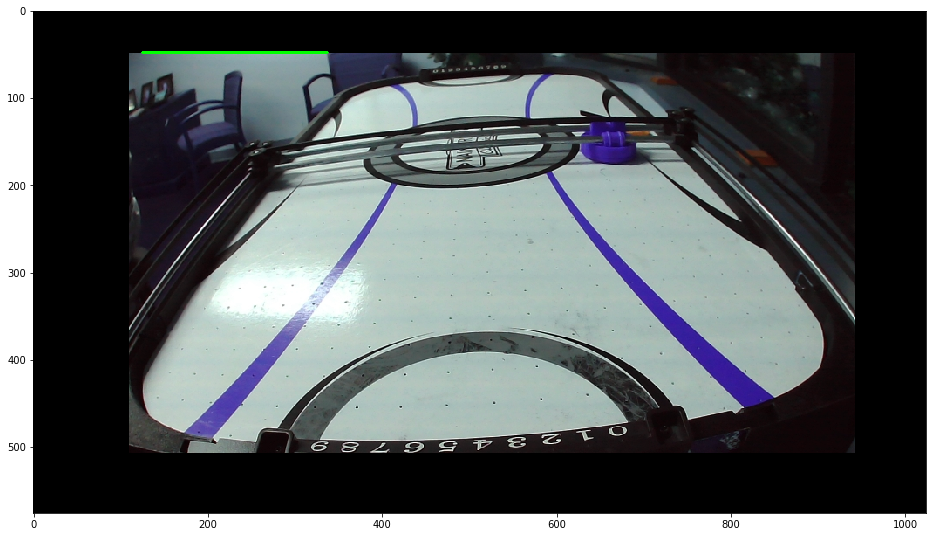

In [49]:
disp = just_rect.copy()

lines = cv2.HoughLinesP(edges,1,np.pi/32,100)

for x1,y1,x2,y2 in lines[0]:
    cv2.line(disp,(x1,y1),(x2,y2),(0,255,0),2)

show_img(disp)

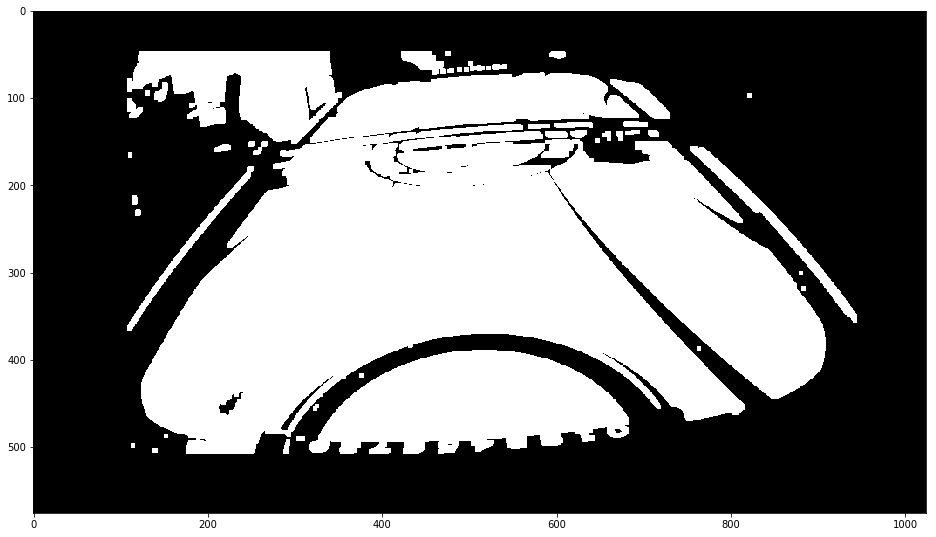

In [10]:
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(thresh, kernel, iterations = 1)
show_img(dilation)

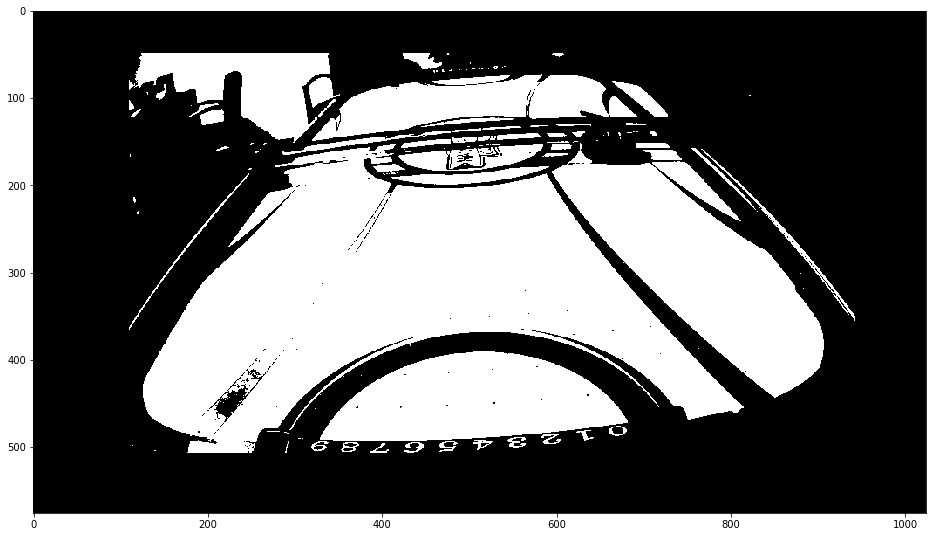

In [13]:
from skimage import segmentation, filters, img_as_ubyte

mask = just_gray > filters.threshold_otsu(just_gray)
clean_border = segmentation.clear_border(mask)
show_img(clean_border)

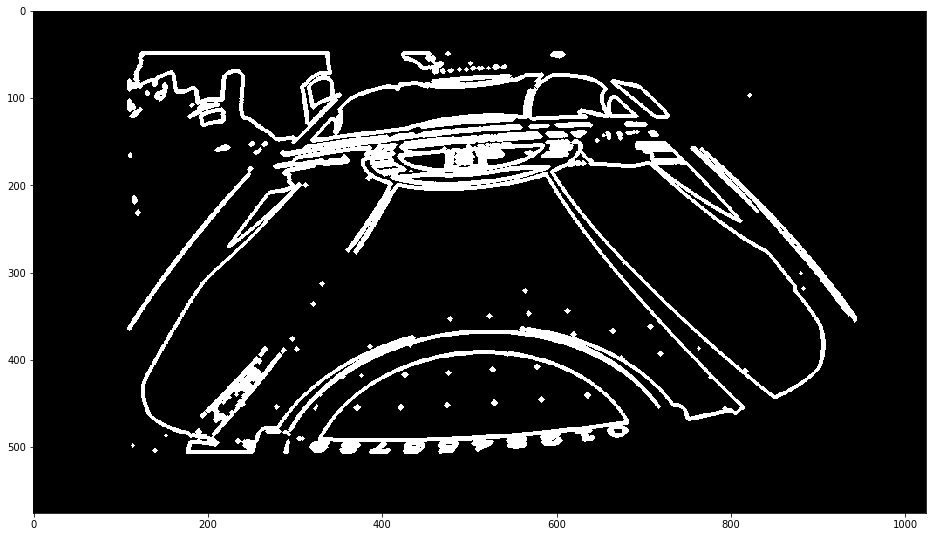

In [14]:
cv_image = img_as_ubyte(clean_border)
no_lava = np.zeros_like(cv_image)
im2, contours, hierarchy = cv2.findContours(cv_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
c = max(contours, key = cv2.contourArea)
cv2.drawContours(no_lava, contours, -1, (255,255,255), 3)
show_img(no_lava)

In [15]:
def remove_noise(image):
    wk_img=image.copy()
    
    # Baseline params
    kernel1=5
    kernel2=60
    while True:    
        kernel = np.ones((kernel1,kernel2))
        opened=cv2.morphologyEx(wk_img,cv2.MORPH_OPEN, kernel)    
        zero_count_l=np.count_nonzero(opened[:,:120])
        zero_count_r=np.count_nonzero(opened[:,1780:])
        if zero_count_l > 0 or zero_count_r > 0:
            kernel2+=1
        else:
            break

    closed=cv2.morphologyEx(opened, cv2.MORPH_CLOSE, np.ones((10,10)))
    return closed.copy()

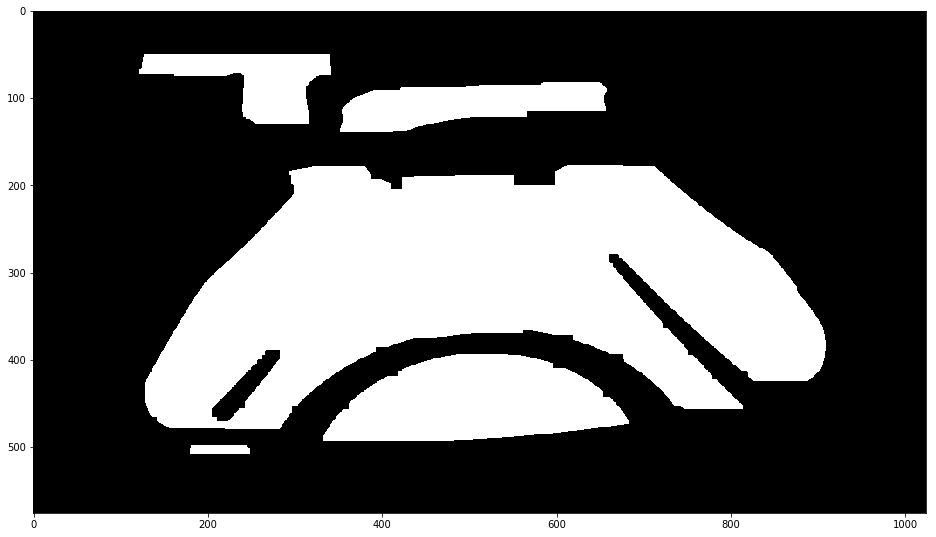

In [16]:
clean_img = remove_noise(cv_image)
show_img(clean_img)

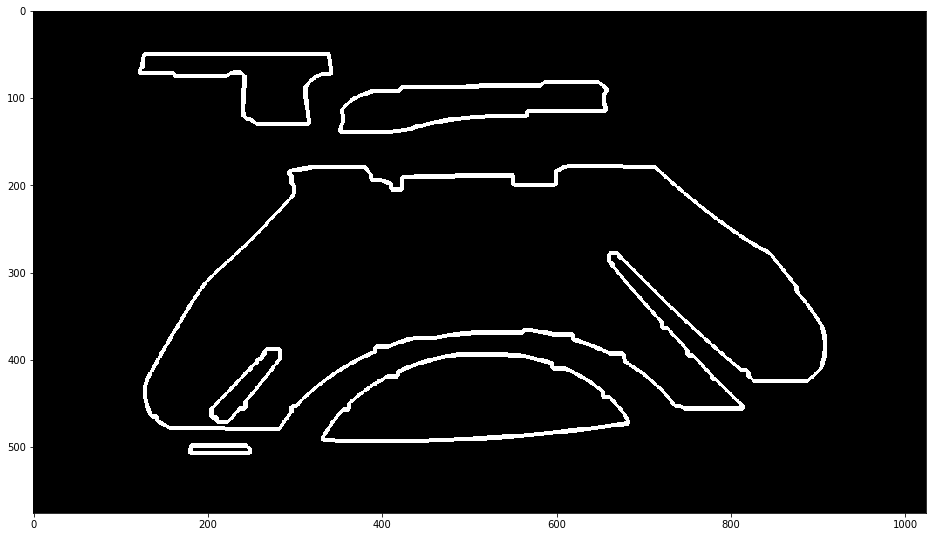

In [50]:
no_lava = np.zeros_like(clean_img)
im2, contours, hierarchy = cv2.findContours(clean_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(no_lava, contours, -1, (255,255,255), 3)
show_img(no_lava)

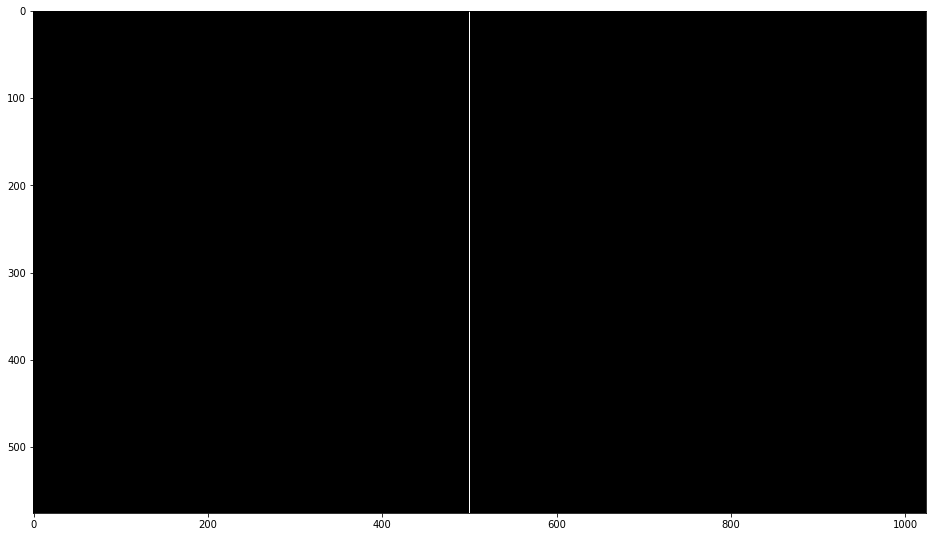

In [112]:
line = np.zeros_like(no_lava)
line[:, 500:501] = 1
show_img(line)

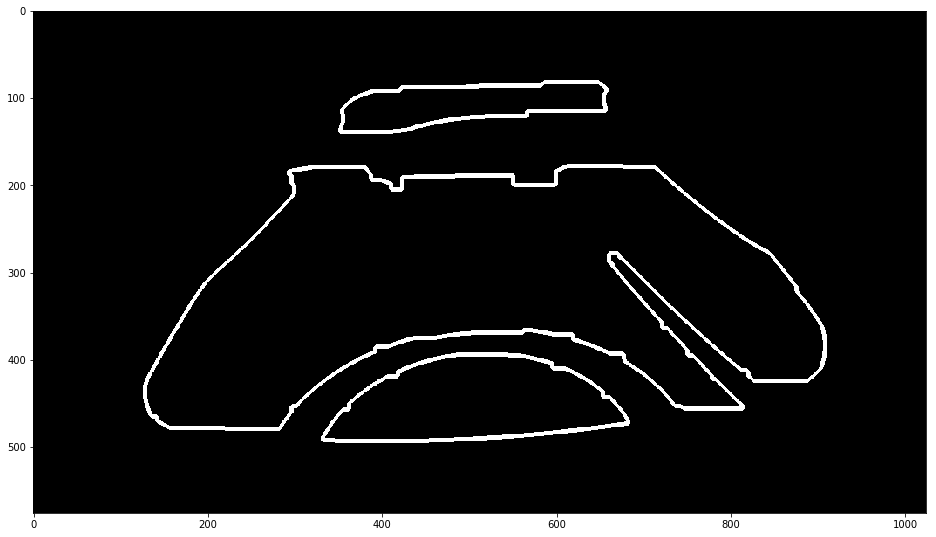

In [125]:
touches_line = []
for contour in contours:
    touches = np.zeros_like(no_lava)
    cv2.drawContours(touches, [contour], -1, (255,255,255), 3)
    if np.any(touches & line):
        touches_line.append(contour)

liners = np.zeros_like(no_lava)
cv2.drawContours(liners, touches_line, -1, (255,255,255), 3)
show_img(liners)

[[[  37.38666  521.2796 ]]

 [[1027.4198   461.2776 ]]

 [[ 490.4786   -81.286  ]]]


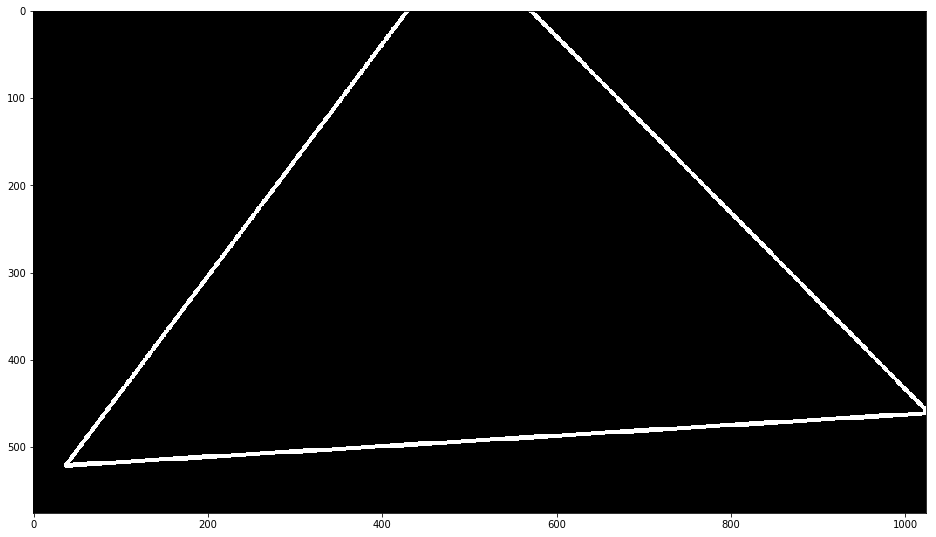

In [134]:
a, triangle = cv2.minEnclosingTriangle(np.array([np.argwhere(liners.T)]))
tri = np.zeros_like(no_lava)
tri = cv2.polylines(tri, np.int32([triangle]), True, (255, 255, 255), 3)
print(triangle)
show_img(tri)


In [132]:
tuple([5, 5])

(5, 5)